# Preparación de entorno y dataset

In [1]:
! pip install pyarrow
! pip install -q kaggle

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
pd.options.display.float_format = '{:20,.4f}'.format # suprimimos la notacion cientifica en los outputs

In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hangyeolkoo","key":"4032f7e1f591049aec886c05d7504de2"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download vpn-classification -f dataset_v2/train.parq

100% 563M/564M [00:21<00:00, 23.0MB/s]
100% 564M/564M [00:21<00:00, 28.1MB/s]


In [9]:
! kaggle competitions download vpn-classification -f dataset_v2/shodan_df_hashed.csv

 47% 1.00M/2.11M [00:00<00:00, 2.00MB/s]
100% 2.11M/2.11M [00:00<00:00, 3.57MB/s]


In [10]:
! unzip train.parq.zip

Archive:  train.parq.zip
  inflating: train.parq              


In [11]:
! unzip shodan_df_hashed.csv.zip

Archive:  shodan_df_hashed.csv.zip
  inflating: shodan_df_hashed.csv    


## Manejo de train dataset

In [12]:
train = pd.read_parquet("train.parq",engine="auto")

In [13]:
train.head()

,attack_time,watcher_country,watcher_as_num,watcher_as_name,attacker_country,attacker_as_num,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum,label
0,2023-07-31 07:17:51+00:00,DE,"34,011.0000",Host Europe GmbH,TR,"47,721.0000",Murat Aktas,http:exploit,0,6466,0
1,2023-07-31 07:17:51+00:00,DE,"34,011.0000",Host Europe GmbH,TR,"47,721.0000",Murat Aktas,http:spam,0,6466,0
2,2023-07-31 07:17:49+00:00,DE,"20,886.0000",bn:t Blatzheim Networks Telecom GmbH,DE,"51,167.0000",Contabo GmbH,http:bruteforce,2,4637,0
3,2023-07-31 07:17:49+00:00,DE,"20,886.0000",bn:t Blatzheim Networks Telecom GmbH,DE,"51,167.0000",Contabo GmbH,http:spam,2,4637,0
4,2023-07-31 07:17:49+00:00,DE,"20,886.0000",bn:t Blatzheim Networks Telecom GmbH,DE,"51,167.0000",Contabo GmbH,http:exploit,2,4637,0


In [14]:
train.isna().sum().sum()

822426

In [15]:
train['label'].value_counts()

0    60594448
1     1035237
Name: label, dtype: int64

In [16]:
train = train.dropna()

In [17]:
train['label'].value_counts()

0    60135084
1     1026672
Name: label, dtype: int64

In [18]:
train = train.drop(columns=['watcher_as_name','attacker_as_name'])

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61161756 entries, 0 to 61629684
Data columns (total 9 columns):
 #   Column             Dtype              
---  ------             -----              
 0   attack_time        datetime64[ns, UTC]
 1   watcher_country    category           
 2   watcher_as_num     float32            
 3   attacker_country   category           
 4   attacker_as_num    float32            
 5   attack_type        category           
 6   watcher_uuid_enum  int32              
 7   attacker_ip_enum   int32              
 8   label              int8               
dtypes: category(3), datetime64[ns, UTC](1), float32(2), int32(2), int8(1)
memory usage: 2.2 GB


Las columnas que aportan informaciones equivalentes a otra ya existente fueron descartadas.

## Conversión de features

In [19]:
def map_day_name_to_day_int(day_name):
  list_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
  for i in range(7):
    if day_name == list_days[i]:
      return i
  return day_name

In [20]:
train['day_of_week'] = train['attack_time'].dt.day_name().map(map_day_name_to_day_int)

In [21]:
train['hour'] = train['attack_time'].dt.hour

In [22]:
def between(a, x, b):
  return (a <= x < b)

def map_hour(hour):
  if between(0, hour, 4):
    return '0-4'
  if between(4, hour, 8):
    return '4-8'
  if between(8, hour, 12):
    return '8-12'
  if between(12, hour, 16):
    return '12-16'
  if between(16, hour, 20):
    return '16-20'
  if between(20, hour, 24):
    return '20-24'
  return hour

In [23]:
train['hours_interval'] = train['hour'].map(map_hour)

In [24]:
train = train.drop(columns=['attack_time'])

In [25]:
train[['service', 'threat_type']] = train['attack_type'].str.split(':', expand=True)

In [26]:
train['same_country'] = (train['attacker_country'].astype('str') == train['watcher_country'].astype('str')).astype(int)

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61161756 entries, 0 to 61629684
Data columns (total 14 columns):
 #   Column             Dtype   
---  ------             -----   
 0   watcher_country    category
 1   watcher_as_num     float32 
 2   attacker_country   category
 3   attacker_as_num    float32 
 4   attack_type        category
 5   watcher_uuid_enum  int32   
 6   attacker_ip_enum   int32   
 7   label              int8    
 8   day_of_week        int64   
 9   hour               int64   
 10  hours_interval     object  
 11  service            object  
 12  threat_type        object  
 13  same_country       int64   
dtypes: category(3), float32(2), int32(2), int64(3), int8(1), object(3)
memory usage: 4.4+ GB


In [28]:
train['day_of_week'] = train['day_of_week'].astype('int8')
train['hour'] = train['hour'].astype('int8')
train['service'] = train['service'].astype('category')
train['threat_type'] = train['threat_type'].astype('category')
train['same_country'] = train['same_country'].astype('category')

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61161756 entries, 0 to 61629684
Data columns (total 14 columns):
 #   Column             Dtype   
---  ------             -----   
 0   watcher_country    category
 1   watcher_as_num     float32 
 2   attacker_country   category
 3   attacker_as_num    float32 
 4   attack_type        category
 5   watcher_uuid_enum  int32   
 6   attacker_ip_enum   int32   
 7   label              int8    
 8   day_of_week        int8    
 9   hour               int8    
 10  hours_interval     object  
 11  service            category
 12  threat_type        category
 13  same_country       category
dtypes: category(6), float32(2), int32(2), int8(3), object(1)
memory usage: 2.4+ GB


In [30]:
train.head()

,watcher_country,watcher_as_num,attacker_country,attacker_as_num,attack_type,watcher_uuid_enum,attacker_ip_enum,label,day_of_week,hour,hours_interval,service,threat_type,same_country
0,DE,"34,011.0000",TR,"47,721.0000",http:exploit,0,6466,0,0,7,4-8,http,exploit,0
1,DE,"34,011.0000",TR,"47,721.0000",http:spam,0,6466,0,0,7,4-8,http,spam,0
2,DE,"20,886.0000",DE,"51,167.0000",http:bruteforce,2,4637,0,0,7,4-8,http,bruteforce,1
3,DE,"20,886.0000",DE,"51,167.0000",http:spam,2,4637,0,0,7,4-8,http,spam,1
4,DE,"20,886.0000",DE,"51,167.0000",http:exploit,2,4637,0,0,7,4-8,http,exploit,1


In [31]:
train['attack_count_per_ip'] = train.groupby('attacker_ip_enum')['attacker_ip_enum'].transform('count')

In [32]:
train_grouped_by_ip_enum = train.groupby('attacker_ip_enum').agg({
    'attack_count_per_ip' : 'first',
    'watcher_country': lambda x: x.mode().iat[0],
    'watcher_as_num': lambda x: x.mode().iat[0],
    'attacker_country': lambda x: x.mode().iat[0],
    'attacker_as_num': lambda x: x.mode().iat[0],
    'attack_type': lambda x: x.mode().iat[0],
    'watcher_uuid_enum': lambda x: x.mode().iat[0],
    'label': lambda x: x.mode().iat[0],
    'day_of_week': 'mean',
    'hour': 'mean',
    'service': lambda x: x.mode().iat[0],
    'threat_type': lambda x: x.mode().iat[0],
    'same_country': lambda x: x.mode().iat[0]
}).reset_index()

train_grouped_by_ip_enum.head()

,attacker_ip_enum,attack_count_per_ip,watcher_country,watcher_as_num,attacker_country,attacker_as_num,attack_type,watcher_uuid_enum,label,day_of_week,hour,service,threat_type,same_country
0,0,52,US,"14,061.0000",US,"14,618.0000",http:scan,18401,0,4.0000,17.7692,http,scan,0
1,1,30,US,"3,303.0000",BR,"27,699.0000",http:exploit,8646,0,1.0000,14.1000,http,exploit,0
2,2,58,DE,"12,897.0000",DE,"3,320.0000",http:scan,24879,0,3.0862,11.2241,http,scan,1
3,3,22,DE,"12,897.0000",VE,"21,826.0000",http:exploit,24879,0,3.6818,13.5909,http,exploit,0
4,4,68,US,"396,982.0000",SA,"25,019.0000",http:exploit,1828,0,3.3235,19.0882,http,exploit,0


## Manejo de shodan_info

In [33]:
shodan_df = pd.read_csv('shodan_df_hashed.csv')

In [34]:
shodan_df.head()

,shodan_info,attacker_ip_enum
0,{},5915
1,"{'22/tcp': {'headers_hash': None, 'jarm': None...",3325
2,{},8416
3,{},1213
4,{},9185


In [35]:
len(shodan_df) == len(shodan_df['attacker_ip_enum'].unique())

True

In [36]:
import ast
from collections import Counter

port_counter = Counter()
ip_port_list = {}

for index, row in shodan_df.iterrows():
  shodan_info = ast.literal_eval(row['shodan_info'])
  ip_port_list[int(row['attacker_ip_enum'])] = list(shodan_info)
  port_counter.update(shodan_info.keys())

In [37]:
ip_port_count = {}
for ip in ip_port_list:
  ip_port_count[ip] = len(ip_port_list[ip])

In [38]:
len(port_counter.keys())

2297

In [39]:
port_counter.most_common()[10]

('587/tcp', 2300)

In [40]:
top_port = set()
for port in port_counter.most_common(10):
  top_port.add(port[0])

In [41]:
for ip in ip_port_list:
  for port in ip_port_list[ip]:
    if port not in top_port:
      ip_port_list[ip].remove(port)

In [42]:
train_grouped_by_ip_enum['port_count'] = train_grouped_by_ip_enum['attacker_ip_enum'].map(ip_port_count)
train_grouped_by_ip_enum['port_list'] = train_grouped_by_ip_enum['attacker_ip_enum'].map(ip_port_list)

In [43]:
for port in top_port:
  train_grouped_by_ip_enum[port] = train_grouped_by_ip_enum['port_list'].map(lambda port_list: int(port in port_list))

In [44]:
train_grouped_by_ip_enum = train_grouped_by_ip_enum.drop(columns='port_list')

## Dataset resultante

In [45]:
train_grouped_by_ip_enum.head()

,attacker_ip_enum,attack_count_per_ip,watcher_country,watcher_as_num,attacker_country,attacker_as_num,attack_type,watcher_uuid_enum,label,day_of_week,...,21/tcp,53/udp,443/tcp,993/tcp,2000/tcp,53/tcp,22/tcp,80/tcp,465/tcp,995/tcp
0,0,52,US,"14,061.0000",US,"14,618.0000",http:scan,18401,0,4.0000,...,0,0,0,0,0,0,0,0,0,0
1,1,30,US,"3,303.0000",BR,"27,699.0000",http:exploit,8646,0,1.0000,...,0,0,0,0,0,0,0,0,0,0
2,2,58,DE,"12,897.0000",DE,"3,320.0000",http:scan,24879,0,3.0862,...,0,0,0,0,0,0,0,0,0,0
3,3,22,DE,"12,897.0000",VE,"21,826.0000",http:exploit,24879,0,3.6818,...,0,0,0,0,0,0,0,0,0,0
4,4,68,US,"396,982.0000",SA,"25,019.0000",http:exploit,1828,0,3.3235,...,0,0,0,0,0,0,0,0,0,0


# Exploración de Dataset

## Cantidad de ataques por label

In [46]:
train_grouped_by_ip_enum['label'].value_counts()

0    144776
1      2873
Name: label, dtype: int64

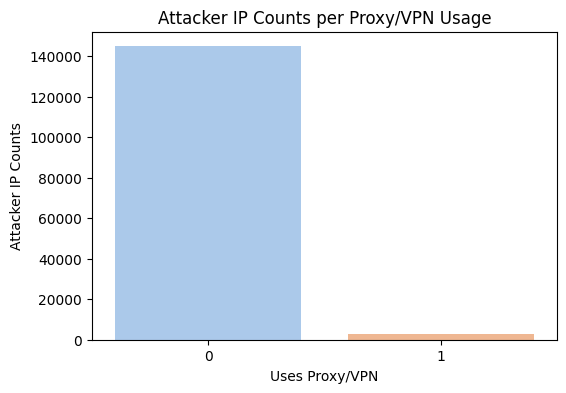

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label',
              data=train_grouped_by_ip_enum,
              palette='pastel')
plt.title('Attacker IP Counts per Proxy/VPN Usage')
plt.xlabel('Uses Proxy/VPN')
plt.ylabel('Attacker IP Counts')
plt.show()

El desequilibrio indica que dependiendo del caso puede que necesitemos undersamplear.

## Pais atacante y pais atacado

In [48]:
cantidad_ataques_por_pais_atacante = train.groupby(['attacker_country']).size().reset_index(name='count')
cantidad_ataques_por_pais_atacante.sort_values(by='count', ascending=False,inplace=True)
cantidad_ataques_por_pais_atacante

,attacker_country,count
200,US,16634803
48,DE,5668976
174,SG,4460661
39,CN,4068982
146,NL,3057476
...,...,...
97,JE,17
143,NE,17
70,GG,17
63,FO,10


In [49]:
label_mean_por_pais_atacante = train.groupby(['attacker_country']).agg({'label':'mean'}).reset_index()
label_mean_por_pais_atacante.sort_values(by='label', ascending=False, inplace=True)
label_mean_por_pais_atacante

,attacker_country,label
208,WS,1.0000
84,HN,0.4821
171,SC,0.1594
95,IS,0.0942
32,CA,0.0939
...,...,...
99,JO,0.0000
104,KM,0.0000
105,KN,0.0000
106,KP,0.0000


Inner join(el default) preserva el orden del dataframe izquierdo.

In [50]:
cantidad_ataques_y_label_promedio_por_pais_atacante = pd.merge(cantidad_ataques_por_pais_atacante, label_mean_por_pais_atacante)
cantidad_ataques_y_label_promedio_por_pais_atacante

,attacker_country,count,label
0,US,16634803,0.0198
1,DE,5668976,0.0128
2,SG,4460661,0.0305
3,CN,4068982,0.0053
4,NL,3057476,0.0051
...,...,...,...
209,JE,17,0.0000
210,NE,17,0.0000
211,GG,17,0.0000
212,FO,10,0.0000


Barplot muestra todas las categorías existentes independientemente de los presentes en el dataframe a la hora de plotear columnas categóricas, por lo que se debe convertirlos en string.

In [51]:
top_15_paises_atacantes_por_cantidad_de_ataques_con_label_mean = cantidad_ataques_y_label_promedio_por_pais_atacante.head(15).copy()
top_15_paises_atacantes_por_cantidad_de_ataques_con_label_mean['attacker_country'] = top_15_paises_atacantes_por_cantidad_de_ataques_con_label_mean['attacker_country'].astype('str')

In [52]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

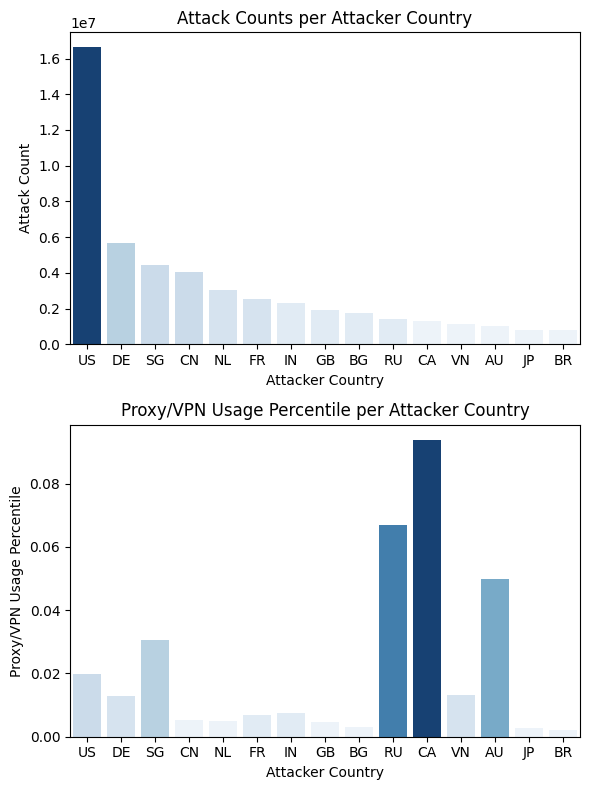

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8))
sns.barplot(x='attacker_country',
            y='count',
            data=top_15_paises_atacantes_por_cantidad_de_ataques_con_label_mean,
            palette=(colors_from_values(top_15_paises_atacantes_por_cantidad_de_ataques_con_label_mean['count'],'Blues')),
            ax=axes[0])
axes[0].set_title('Attack Counts per Attacker Country')
axes[0].set_xlabel('Attacker Country')
axes[0].set_ylabel('Attack Count')
sns.barplot(x='attacker_country',
            y='label',
            data=top_15_paises_atacantes_por_cantidad_de_ataques_con_label_mean,
            palette=(colors_from_values(top_15_paises_atacantes_por_cantidad_de_ataques_con_label_mean['label'],'Blues')),
            ax=axes[1])
axes[1].set_title('Proxy/VPN Usage Percentile per Attacker Country')
axes[1].set_xlabel('Attacker Country')
axes[1].set_ylabel('Proxy/VPN Usage Percentile')
plt.tight_layout()
plt.show()

In [54]:
cantidad_ataques_por_pais_atacado = train.groupby(['watcher_country']).size().reset_index(name='count')
cantidad_ataques_por_pais_atacado.sort_values(by='count', ascending=False, inplace=True)
cantidad_ataques_por_pais_atacado

,watcher_country,count
123,US,21592838
32,DE,11811880
42,FR,4851364
43,GB,3101047
90,NL,3006675
...,...,...
83,MV,10
58,IM,9
10,BB,9
68,KW,2


In [55]:
label_mean_por_pais_atacado = train.groupby(['watcher_country']).agg({'label':'mean'}).reset_index()
label_mean_por_pais_atacado.sort_values(by='label', ascending=False, inplace=True)
label_mean_por_pais_atacado

,watcher_country,label
88,NG,0.1475
76,MD,0.1161
55,ID,0.0970
46,GH,0.0682
70,LI,0.0645
...,...,...
81,MT,0.0000
83,MV,0.0000
86,NA,0.0000
99,PR,0.0000


In [56]:
cantidad_ataques_y_label_promedio_por_pais_atacado = pd.merge(cantidad_ataques_por_pais_atacado, label_mean_por_pais_atacado)
cantidad_ataques_y_label_promedio_por_pais_atacado

,watcher_country,count,label
0,US,21592838,0.0182
1,DE,11811880,0.0121
2,FR,4851364,0.0180
3,GB,3101047,0.0190
4,NL,3006675,0.0179
...,...,...,...
125,MV,10,0.0000
126,IM,9,0.0000
127,BB,9,0.0000
128,KW,2,0.0000


In [57]:
top_15_paises_atacados_por_cantidad_de_ataques_con_label_mean = cantidad_ataques_y_label_promedio_por_pais_atacado.head(15).copy()
top_15_paises_atacados_por_cantidad_de_ataques_con_label_mean['watcher_country'] = top_15_paises_atacados_por_cantidad_de_ataques_con_label_mean['watcher_country'].astype('str')

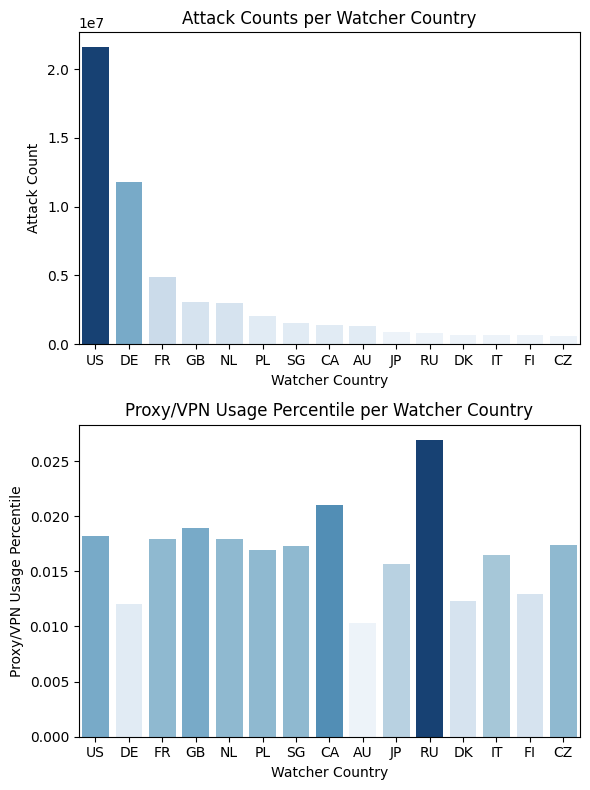

In [58]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8))
sns.barplot(x='watcher_country',
            y='count',
            data=top_15_paises_atacados_por_cantidad_de_ataques_con_label_mean,
            palette=(colors_from_values(top_15_paises_atacados_por_cantidad_de_ataques_con_label_mean['count'],'Blues')),
            ax=axes[0])
axes[0].set_title('Attack Counts per Watcher Country')
axes[0].set_xlabel('Watcher Country')
axes[0].set_ylabel('Attack Count')
sns.barplot(x='watcher_country',
            y='label',
            data=top_15_paises_atacados_por_cantidad_de_ataques_con_label_mean,
            palette=(colors_from_values(top_15_paises_atacados_por_cantidad_de_ataques_con_label_mean['label'],'Blues')),
            ax=axes[1])
axes[1].set_title('Proxy/VPN Usage Percentile per Watcher Country')
axes[1].set_xlabel('Watcher Country')
axes[1].set_ylabel('Proxy/VPN Usage Percentile')
plt.tight_layout()
plt.show()

In [59]:
label_mean_por_paises_iguales = train.groupby(['same_country']).agg({'label':'mean'}).reset_index()
label_mean_por_paises_iguales.sort_values(by='label', ascending=False)

,same_country,label
0,0,0.0173
1,1,0.0144


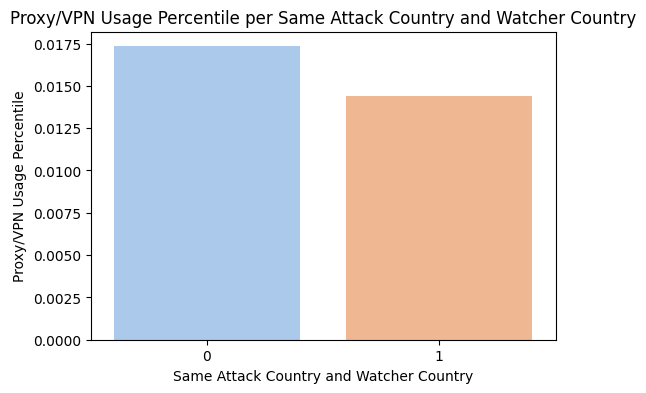

In [60]:
plt.figure(figsize=(6, 4))
sns.barplot(x='same_country',
              y='label',
              data=label_mean_por_paises_iguales,
              palette='pastel')
plt.title('Proxy/VPN Usage Percentile per Same Attack Country and Watcher Country')
plt.xlabel('Same Attack Country and Watcher Country')
plt.ylabel('Proxy/VPN Usage Percentile')
plt.show()

## Tipo de ataque

In [61]:
cantidad_ataques_por_tipo_amenaza = train.groupby(['threat_type']).size().reset_index(name='count')
cantidad_ataques_por_tipo_amenaza = cantidad_ataques_por_tipo_amenaza.sort_values(by='count', ascending=False).reset_index(drop=True)
cantidad_ataques_por_tipo_amenaza

,threat_type,count
0,spam,17150531
1,scan,16834467
2,exploit,15200536
3,bruteforce,11557376
4,unknown,323955
5,crawl,94891


In [62]:
label_mean_por_tipo_amenaza = train.groupby(['threat_type']).agg({'label':'mean'}).reset_index()
label_mean_por_tipo_amenaza = label_mean_por_tipo_amenaza.sort_values(by='label', ascending=False).reset_index(drop=True)
label_mean_por_tipo_amenaza

,threat_type,label
0,crawl,0.0536
1,exploit,0.0200
2,spam,0.0184
3,unknown,0.0166
4,bruteforce,0.0141
5,scan,0.0139


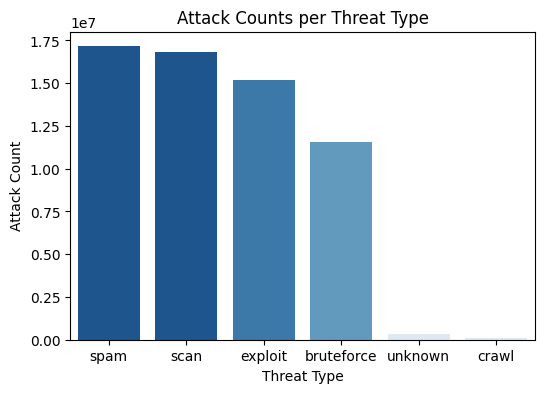

In [63]:
desired_order = cantidad_ataques_por_tipo_amenaza['threat_type'].tolist()

plt.figure(figsize=(6, 4))
sns.barplot(x='threat_type',
            y='count',
            data=cantidad_ataques_por_tipo_amenaza,
            palette=(colors_from_values(cantidad_ataques_por_tipo_amenaza['count'],'Blues')),
            order=desired_order)
plt.title('Attack Counts per Threat Type')
plt.xlabel('Threat Type')
plt.ylabel('Attack Count')
plt.show()

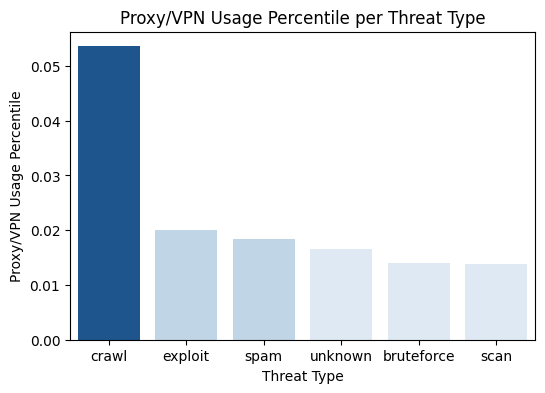

In [64]:
desired_order = label_mean_por_tipo_amenaza['threat_type'].tolist()

plt.figure(figsize=(6, 4))
sns.barplot(x='threat_type',
            y='label',
            data=label_mean_por_tipo_amenaza,
            palette=(colors_from_values(label_mean_por_tipo_amenaza['label'],'Blues')),
            order=desired_order)
plt.title('Proxy/VPN Usage Percentile per Threat Type')
plt.xlabel('Threat Type')
plt.ylabel('Proxy/VPN Usage Percentile')
plt.show()

In [65]:
cantidad_ataques_por_servicio = train.groupby(['service']).size().reset_index(name='count')
cantidad_ataques_por_servicio = cantidad_ataques_por_servicio.sort_values(by='count', ascending=False).reset_index(drop=True)
cantidad_ataques_por_servicio

,service,count
0,http,54022506
1,ssh,5254421
2,windows,568374
3,pop3/imap,439596
4,unknown,323955
5,tcp,311207
6,sip,224956
7,smb,12416
8,telnet,2395
9,ftp,1477


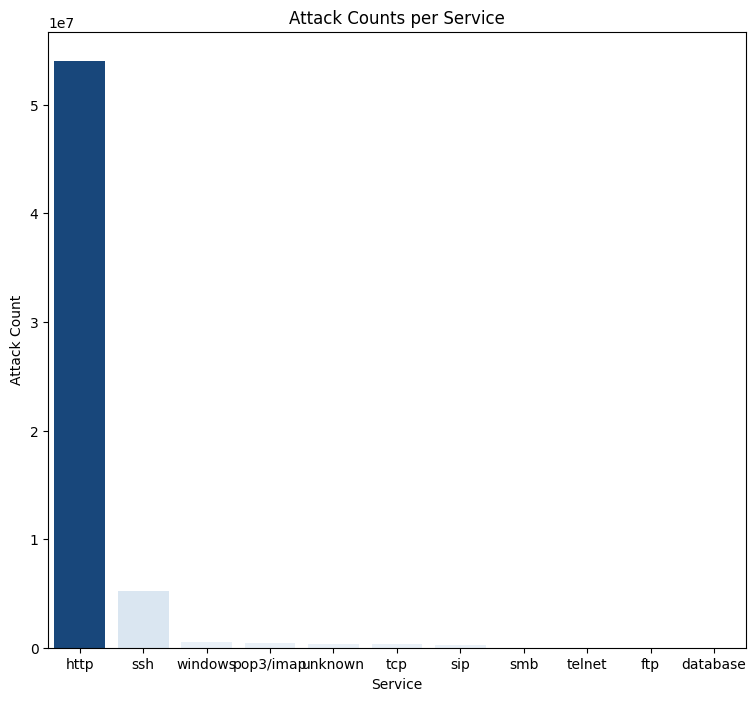

In [66]:
desired_order = cantidad_ataques_por_servicio['service'].tolist()

plt.figure(figsize=(9, 8))
sns.barplot(x='service',
            y='count',
            data=cantidad_ataques_por_servicio,
            palette=(colors_from_values(cantidad_ataques_por_servicio['count'],'Blues')),
            order=desired_order)
plt.title('Attack Counts per Service')
plt.xlabel('Service')
plt.ylabel('Attack Count')
plt.show()

In [67]:
label_mean_por_servicio = train.groupby(['service']).agg({'label':'mean'}).reset_index()
label_mean_por_servicio = label_mean_por_servicio.sort_values(by='label', ascending=False).reset_index(drop=True)
label_mean_por_servicio

,service,label
0,pop3/imap,0.0234
1,http,0.0171
2,unknown,0.0166
3,ssh,0.0166
4,telnet,0.0079
5,tcp,0.0002
6,sip,0.0000
7,windows,0.0000
8,database,0.0000
9,ftp,0.0000


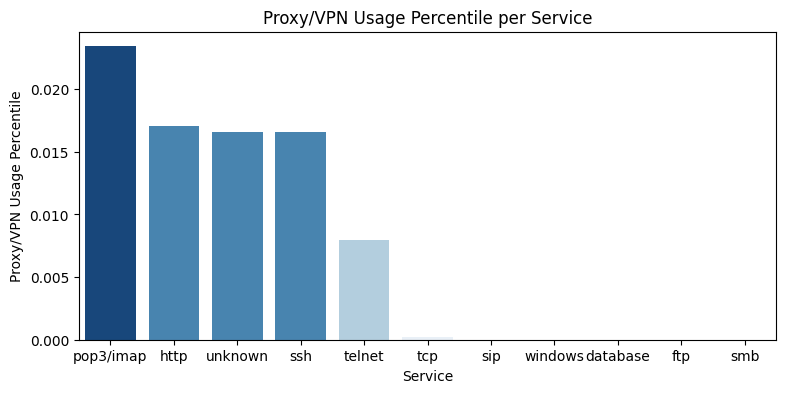

In [68]:
desired_order = label_mean_por_servicio['service'].tolist()

plt.figure(figsize=(9, 4))
sns.barplot(x='service',
            y='label',
            data=label_mean_por_servicio,
            palette=(colors_from_values(label_mean_por_servicio['label'],'Blues')),
            order=desired_order)
plt.title('Proxy/VPN Usage Percentile per Service')
plt.xlabel('Service')
plt.ylabel('Proxy/VPN Usage Percentile')
plt.show()

In [69]:
label_mean_por_tipo_ataque = train.groupby(['attack_type']).agg({'label':'mean'}).reset_index()
label_mean_por_tipo_ataque = label_mean_por_tipo_ataque.sort_values(by='label', ascending=False).reset_index(drop=True)
label_mean_por_tipo_ataque

,attack_type,label
0,http:crawl,0.0536
1,pop3/imap:bruteforce,0.0234
2,http:exploit,0.0200
3,http:spam,0.0184
4,unknown:unknown,0.0166
5,ssh:bruteforce,0.0166
6,http:scan,0.0141
7,http:bruteforce,0.0130
8,telnet:bruteforce,0.0079
9,tcp:scan,0.0002


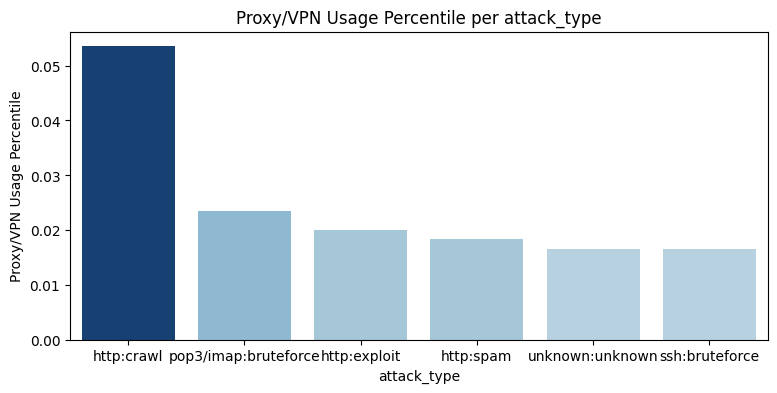

In [70]:
desired_order = (label_mean_por_tipo_ataque['attack_type'].tolist())[:6]

plt.figure(figsize=(9, 4))
sns.barplot(x='attack_type',
            y='label',
            data=label_mean_por_tipo_ataque,
            palette=(colors_from_values(label_mean_por_tipo_ataque['label'],'Blues')),
            order=desired_order)
plt.title('Proxy/VPN Usage Percentile per attack_type')
plt.xlabel('attack_type')
plt.ylabel('Proxy/VPN Usage Percentile')
plt.show()

## Dia de Semana y Franja Horaria

In [71]:
orden_franja_horaria = ['0-4','4-8','8-12','12-16','16-20','20-24']

In [72]:
cantidad_label_negativo_por_dia = train[train['label']==0].groupby(['day_of_week']).size().reset_index(name='count')
cantidad_label_negativo_por_dia

,day_of_week,count
0,0,9655625
1,1,8599012
2,2,8127401
3,3,8159546
4,4,8497743
5,5,8208820
6,6,8886937


In [73]:
cantidad_label_negativo_por_franja_horaria = train[train['label']==0].groupby(['hours_interval']).size().reset_index(name='count')
cantidad_label_negativo_por_franja_horaria = cantidad_label_negativo_por_franja_horaria.reindex([0,4,5,1,2,3]).reset_index(drop=True)
cantidad_label_negativo_por_franja_horaria

,hours_interval,count
0,0-4,9573368
1,4-8,10841541
2,8-12,10955716
3,12-16,9744901
4,16-20,9784490
5,20-24,9235068


In [74]:
cantidad_label_negativo_por_dia_y_franja_horaria = train[train['label']==0].pivot_table(index='day_of_week', columns='hours_interval', values='attack_type', aggfunc='count', fill_value=0)
cantidad_label_negativo_por_dia_y_franja_horaria = cantidad_label_negativo_por_dia_y_franja_horaria[orden_franja_horaria]
cantidad_label_negativo_por_dia_y_franja_horaria

hours_interval,0-4,4-8,8-12,12-16,16-20,20-24
day_of_week,,,,,,
0,1480433,1748827,1822411,1607414,1528718,1467822
1,1435057,1618556,1654101,1401122,1306738,1183438
2,1208717,1382408,1503214,1261424,1374288,1397350
3,1421584,1535119,1504545,1309652,1245315,1143331
4,1149200,1466678,1572456,1391361,1520039,1398009
5,1415342,1447554,1342121,1359385,1389557,1254861
6,1463035,1642399,1556868,1414543,1419835,1390257


In [75]:
cantidad_label_positivo_por_dia = train[train['label']==1].groupby(['day_of_week']).size().reset_index(name='count')
cantidad_label_positivo_por_dia

,day_of_week,count
0,0,177478
1,1,163936
2,2,124817
3,3,129841
4,4,127692
5,5,145442
6,6,157466


In [76]:
cantidad_label_positivo_por_franja_horaria = train[train['label']==1].groupby(['hours_interval']).size().reset_index(name='count')
cantidad_label_positivo_por_franja_horaria = cantidad_label_positivo_por_franja_horaria.reindex([0,4,5,1,2,3]).reset_index(drop=True)
cantidad_label_positivo_por_franja_horaria

,hours_interval,count
0,0-4,162532
1,4-8,179154
2,8-12,196994
3,12-16,162596
4,16-20,158665
5,20-24,166731


In [77]:
cantidad_label_positivo_por_dia_y_franja_horaria = train[train['label']==1].pivot_table(index='day_of_week', columns='hours_interval', values='attack_type', aggfunc='count', fill_value=0)
cantidad_label_positivo_por_dia_y_franja_horaria = cantidad_label_positivo_por_dia_y_franja_horaria[orden_franja_horaria]
cantidad_label_positivo_por_dia_y_franja_horaria

hours_interval,0-4,4-8,8-12,12-16,16-20,20-24
day_of_week,,,,,,
0,25639,29744,31677,27750,30910,31758
1,24836,31292,33737,25506,18751,29814
2,17636,22690,27908,19865,19305,17413
3,21790,22530,29647,20107,16998,18769
4,18281,20326,23992,21141,17773,26179
5,23534,22912,21121,24807,29686,23382
6,30816,29660,28912,23420,25242,19416


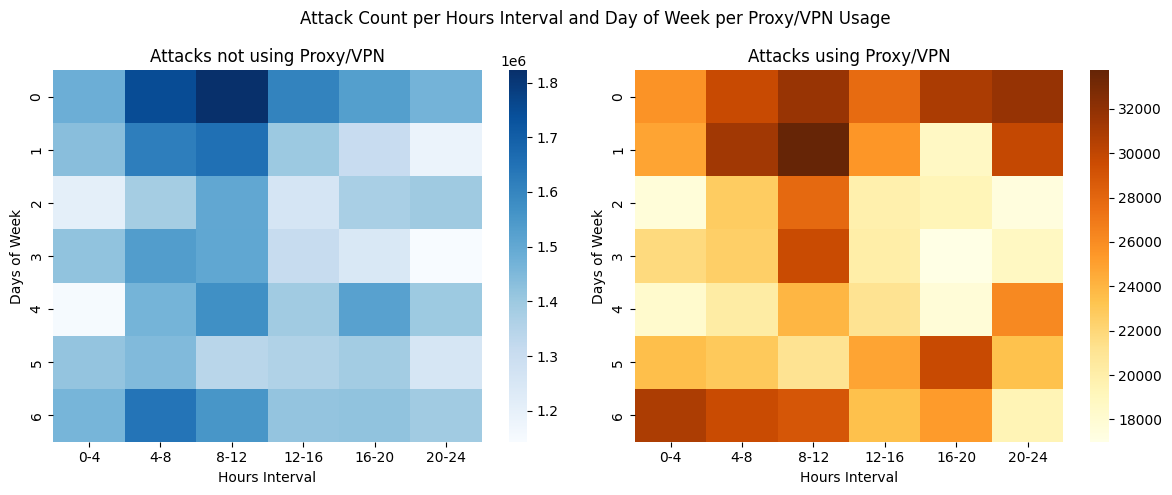

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cantidad_label_negativo_por_dia_y_franja_horaria,
            xticklabels=orden_franja_horaria,
            cmap='Blues',
            ax=axes[0])
axes[0].set_title('Attacks not using Proxy/VPN')
axes[0].set_xlabel('Hours Interval')
axes[0].set_ylabel('Days of Week')

sns.heatmap(cantidad_label_positivo_por_dia_y_franja_horaria,
            xticklabels=orden_franja_horaria,
            cmap='YlOrBr',
            ax=axes[1])
axes[1].set_title('Attacks using Proxy/VPN')
axes[1].set_xlabel('Hours Interval')
axes[1].set_ylabel('Days of Week')

plt.suptitle('Attack Count per Hours Interval and Day of Week per Proxy/VPN Usage')
plt.tight_layout()

plt.show()

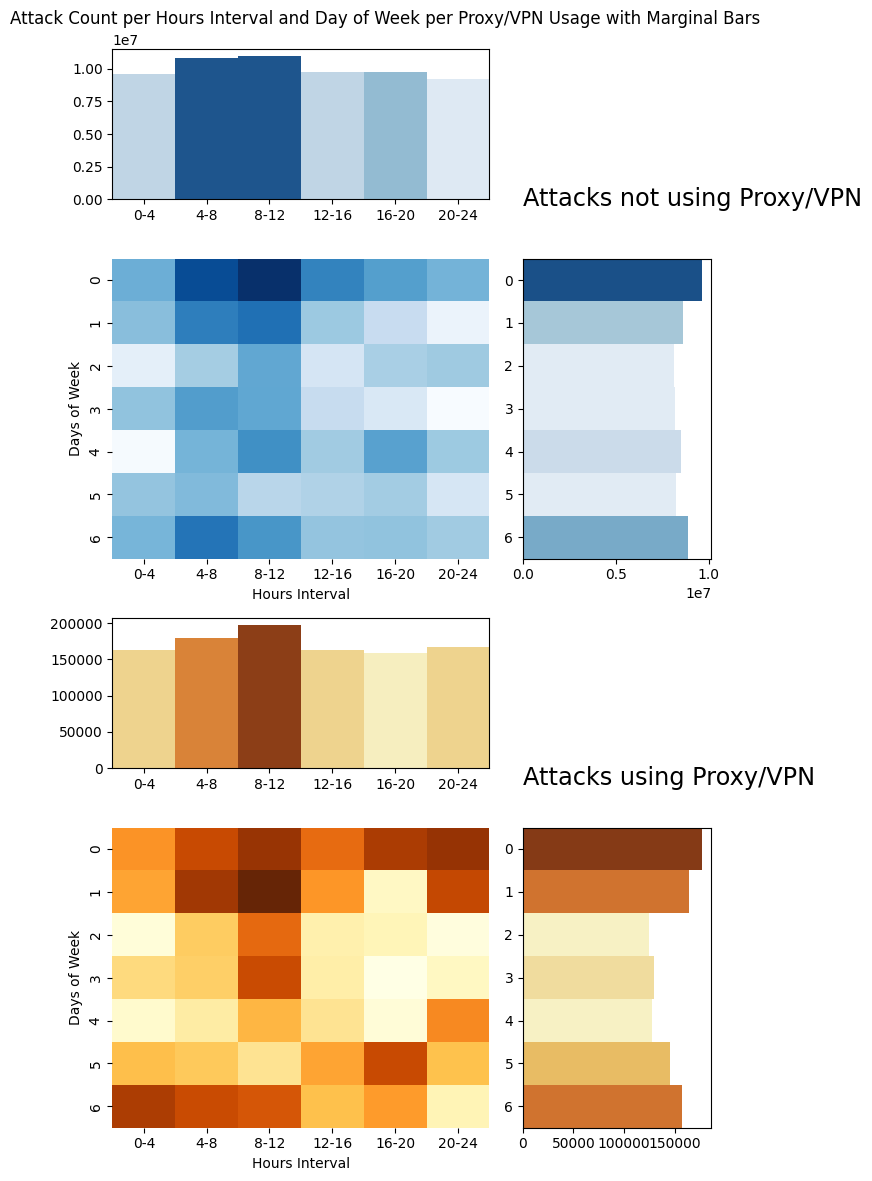

In [101]:
fig, axes = plt.subplots(4, 2, figsize=(7, 12), width_ratios=[1,0.5], height_ratios=[0.5,1,0.5,1])
fig.delaxes(axes[0, 1])
fig.delaxes(axes[2, 1])
sns.heatmap(cantidad_label_negativo_por_dia_y_franja_horaria,
            xticklabels=orden_franja_horaria,
            cmap='Blues',
            ax=axes[1, 0],
            cbar=None)
axes[1][0].set_xlabel('Hours Interval')
axes[1][0].set_ylabel('Days of Week')
sns.barplot(x='hours_interval',
            y='count',
            data=cantidad_label_negativo_por_franja_horaria,
            order=orden_franja_horaria, width=1,
            palette=(colors_from_values(cantidad_label_negativo_por_franja_horaria['count'],'Blues')),
            ax=axes[0, 0])
axes[0][0].set_xlabel('')
axes[0][0].set_ylabel('')
sns.barplot(x='count',
            y='day_of_week',
            data=cantidad_label_negativo_por_dia,
            width=1,
            orient='h',
            palette=(colors_from_values(cantidad_label_negativo_por_dia['count'],'Blues')),
            ax=axes[1, 1])
axes[1][1].set_xlabel('')
axes[1][1].set_ylabel('')


sns.heatmap(cantidad_label_positivo_por_dia_y_franja_horaria,
            xticklabels=orden_franja_horaria,
            cmap='YlOrBr',
            ax=axes[3, 0],
            cbar=None)
axes[3][0].set_xlabel('Hours Interval')
axes[3][0].set_ylabel('Days of Week')
sns.barplot(x='hours_interval',
            y='count',
            data=cantidad_label_positivo_por_franja_horaria,
            order=orden_franja_horaria,
            width=1,
            palette=(colors_from_values(cantidad_label_positivo_por_franja_horaria['count'],'YlOrBr')),
            ax=axes[2, 0])
axes[2][0].set_xlabel('')
axes[2][0].set_ylabel('')
sns.barplot(x='count',
            y='day_of_week',
            data=cantidad_label_positivo_por_dia,
            width=1, orient='h',
            palette=(colors_from_values(cantidad_label_positivo_por_dia['count'],'YlOrBr')),
            ax=axes[3, 1])
axes[3][1].set_xlabel('')
axes[3][1].set_ylabel('')

plt.suptitle('Attack Count per Hours Interval and Day of Week per Proxy/VPN Usage with Marginal Bars')
plt.tight_layout()

plt.text(0, -15, 'Attacks not using Proxy/VPN',{'fontsize':'xx-large'})
plt.text(0, -1.5, 'Attacks using Proxy/VPN',{'fontsize':'xx-large'})


plt.show()

## Shodan info

In [84]:
port_count_mean_per_label = train_grouped_by_ip_enum.groupby('label').agg({'port_count':'mean'}).reset_index()
port_count_mean_per_label

,label,port_count
0,0,0.8057
1,1,5.4765


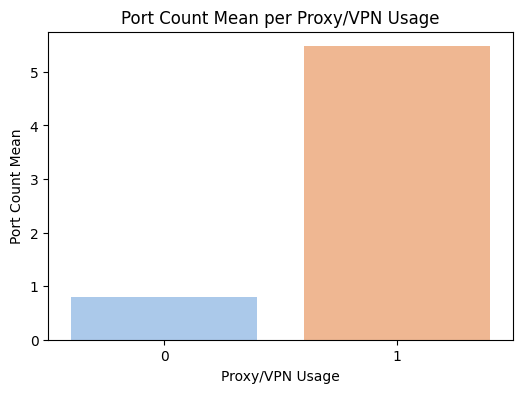

In [87]:
plt.figure(figsize=(6, 4))
sns.barplot(x='label',
              y='port_count',
              data=port_count_mean_per_label,
              palette='pastel')
plt.title('Port Count Mean per Proxy/VPN Usage')
plt.xlabel('Proxy/VPN Usage')
plt.ylabel('Port Count Mean')
plt.show()